## Contingency tables

Evaluating the maximum likelihood fit with Fisher's Exact Test and Logistic Regression.

Does the room type (Private room vs. Entire home/apt) influence the likelihood of a host being a superhost?

[Data source](https://zenodo.org/records/4446043#.Y9Y9ENJBwUE)

**Null**: They are independent  
**Alternative**: They are associated (e.g., private room hosts are more or less likely to be superhosts)

Author: https://www.github.com/deburky

---

### Airbnb Dataset
Dataset includes information such as realSum (the total price of the listing), room_type (private/shared/entire home/apt), host_is_superhost (boolean value indicating if host is a superhost or not), multi (indicator whether listing is for multiple rooms or not), biz (business indicator) , guest_satisfaction_overall (overall rating from guests camparing all listings offered by host ), bedrooms, dist (distance from city center) , lng & lat coordinates for location identification etc.

[Kaggle Airbnb dataset](https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities)  
[Determinants of Airbnb prices in European cities: A spatial econometrics approach](https://zenodo.org/records/4446043#.Y9Y9ENJBwUE)

Given a 2×2 contingency table like this:

|               | Group B = 1 | Group B = 0 |
|---------------|-------------|-------------|
| **Group A = 1** | a       | b      |
| **Group A = 0** | c      | d      |

The **odds ratio (OR)** is computed as:

$$
\text{OR} = \frac{a \times d}{b \times c}
$$

This measures the ratio of the odds of the outcome in one group relative to another. An odds ratio:

- Equal to 1 → no association (independent)
- Greater than 1 → positive association
- Less than 1 → negative association

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from rich.console import Console
from scipy.stats import fisher_exact

console = Console(highlight=False, style="steel_blue3")

# Load the dataset
df = pd.read_csv("airbnb.csv")

# Filter to binary comparison: "Private room" vs "Entire home/apt"
df_filtered = df[df["room_type"].isin(["Private room", "Entire home/apt"])].copy()
df_filtered["is_private_room"] = (df_filtered["room_type"] == "Private room").astype(
    int
)
df_filtered["is_superhost"] = df_filtered["host_is_superhost"].astype(int)

# Contingency table
contingency = pd.crosstab(df_filtered["is_private_room"], df_filtered["is_superhost"])

# Fisher's Exact Test
fisher_oddsratio, fisher_p = fisher_exact(contingency)

# Logistic regression
logit_model = smf.logit("is_superhost ~ is_private_room", data=df_filtered).fit(disp=0)
logit_oddsratio = np.exp(logit_model.params["is_private_room"])

# Predicted probabilities
df_filtered["predicted_proba"] = logit_model.predict(df_filtered[["is_private_room"]])

# Class-wise sums
total_sum_class1_proba = df_filtered["predicted_proba"].sum()
total_sum_class0_proba = (1 - df_filtered["predicted_proba"]).sum()

# Actual class counts
actual_class1_count = df_filtered["is_superhost"].sum()
actual_class0_count = (df_filtered["is_superhost"] == 0).sum()

# Total n
total_n = len(df_filtered)
sum_all_probs = total_sum_class0_proba + total_sum_class1_proba
difference = total_n - sum_all_probs

# Output summary
summary = {
    "Contingency Table": contingency.to_dict(),
    "Fisher's Exact Test": {"odds_ratio": fisher_oddsratio, "p_value": fisher_p},
    "Logistic Regression": {
        "coefficient": logit_model.params["is_private_room"],
        "odds_ratio (exp coef)": logit_oddsratio,
        "p_value": logit_model.pvalues["is_private_room"],
    },
    "Sum of Predicted Probabilities": {
        "Class 1 (superhost)": total_sum_class1_proba,
        "Class 0 (not superhost)": total_sum_class0_proba,
        "Total Sum": sum_all_probs,
        "Total Observations": total_n,
        "Difference": round(difference, 6),
    },
    "Actual Counts": {
        "Class 1 (superhost)": actual_class1_count,
        "Class 0 (not superhost)": actual_class0_count,
    },
}

In [2]:
from rich.align import Align
from rich.panel import Panel
from rich.text import Text
from scipy.stats.contingency import association

logit_summary_text = logit_model.summary().as_text()

panel = Panel(
    Text(logit_summary_text),
    title="Statsmodels Summary",
    border_style="steel_blue3",
)

console.print(Align.center(panel))


cramersv_stat = association(
    contingency,
    method="cramer",
    correction=False,
)
console.print(f"Cramér's V: {cramersv_stat:.4f}")  # Cramér's V

              ╭──────────────────────────────── Statsmodels Summary ────────────────────────────────╮              
              │                            Logit Regression Results                                 │              
              │ ==============================================================================      │              
              │ Dep. Variable:           is_superhost   No. Observations:                51341      │              
              │ Model:                          Logit   Df Residuals:                    51339      │              
              │ Method:                           MLE   Df Model:                            1      │              
              │ Date:                Thu, 22 May 2025   Pseudo R-squ.:                0.002355      │              
              │ Time:                        19:07:36   Log-Likelihood:                -29186.      │              
              │ converged:                       True   LL-Null:                       -29255.      │              
              │ Covariance Type:            nonrobust   LLR p-value:                 8.207e-32      │              
              │ =================================================================================== │              
              │                       coef    std err          z      P>|z|      [0.025      0.975] │              
              │ ----------------------------------------------------------------------------------- │              
              │ Intercept          -0.9747      0.012    -78.542      0.000      -0.999      -0.950 │              
              │ is_private_room    -0.2495      0.021    -11.652      0.000      -0.292      -0.208 │              
              │ =================================================================================== │              
              ╰─────────────────────────────────────────────────────────────────────────────────────╯              

Cramér's V: 0.0515

If a predictor variable in a logistic regression model has an odds ratio less than 1, it means that a one unit increase in that variable is associated with a decrease in the odds of the response variable occurring.

The likelihood of superhost decreases based on private room indicator. Coefficient is significant -0.24 is ~0.79 odds ratio:

$$
\text{OR} = e^{-0.24} \approx 0.79
$$

Private room hosts are ~22% less likely to be superhosts (1 - 0.79 ~ 0.22).

In [3]:
console.print(summary)

{
    'Contingency Table': {0: {0: 23704, 1: 14446}, 1: {0: 8944, 1: 4247}},
    "Fisher's Exact Test": {'odds_ratio': 0.7791561417921334, 'p_value': 8.903168880675683e-32},
    'Logistic Regression': {
        'coefficient': -0.2495438144390995,
        'odds_ratio (exp coef)': 0.7791561417920561,
        'p_value': 2.246546586891894e-31
    },
    'Sum of Predicted Probabilities': {
        'Class 1 (superhost)': 13191.000000000437,
        'Class 0 (not superhost)': 38149.99999999957,
        'Total Sum': 51341.00000000001,
        'Total Observations': 51341,
        'Difference': -0.0
    },
    'Actual Counts': {'Class 1 (superhost)': 13191, 'Class 0 (not superhost)': 38150}
}

Below we print the odds ratio (OR).

The calculation of OR remains invariant to the order of the groups in the table.

The odds ratio is symmetric, meaning that it does not matter which group is assigned to Group A or Group B. The odds ratio will be the same regardless of how the groups are labeled.



In [4]:
# Assuming X = row, y = column
a = contingency.values[0, 0]
b = contingency.values[0, 1]
c = contingency.values[1, 0]
d = contingency.values[1, 1]

ratio = (a * d) / (b * c)
console.print("Odds ratio (a * d) / (b * c):", ratio)
console.print(a, b, c, d)

# Assuming y = row, X = column
contingency_transposed = contingency.T

a = contingency_transposed.values[0, 0]
b = contingency_transposed.values[0, 1]
c = contingency_transposed.values[1, 0]
d = contingency_transposed.values[1, 1]


console.print("Odds ratio: (a * d) / (b * c):", ratio)
console.print(a, b, c, d)

Odds ratio (a * d) / (b * c): 0.7791561417921334

23704 8944 14446 4247

Odds ratio: (a * d) / (b * c): 0.7791561417921334

23704 14446 8944 4247

In [5]:
sum_pred_class_0 = (1 - df_filtered["predicted_proba"]).sum()
sum_pred_class_1 = df_filtered["predicted_proba"].sum()
total_n = sum_pred_class_0 + sum_pred_class_1

console.print(
    f"Sum class 0 probabilities: {sum_pred_class_0:.0f}\n"
    f"Sum class 1 probabilities: {sum_pred_class_1:.0f}\n"
    f"Sum class 0 and class 1 probabilities: {total_n:.0f}"
)

# Actuals
actual_stats = pd.DataFrame(df_filtered["is_superhost"].value_counts())
# add total to actual stats
actual_stats.loc["Total"] = actual_stats.sum()
sum_act_class_0 = actual_stats.loc[0, "count"]
sum_act_class_1 = actual_stats.loc[1, "count"]
total_act_n = sum_act_class_0 + sum_act_class_1

console.print(
    f"\nSum of class 0 observed: {sum_act_class_0:.0f}\n"
    f"Sum of class 1 observed: {sum_act_class_1:.0f}\n"
    f"Sum of class 0 and class 1 observed: {total_act_n:.0f}\n"
)

Sum class 0 probabilities: 38150
Sum class 1 probabilities: 13191
Sum class 0 and class 1 probabilities: 51341

Sum of class 0 observed: 38150
Sum of class 1 observed: 13191
Sum of class 0 and class 1 observed: 51341

In [6]:
from fisher_scoring import LogisticRegression
from sklearn.metrics import roc_auc_score

# Create a LogisticRegression object
log_reg = LogisticRegression()
log_reg.fit(
    df_filtered[["is_private_room"]],
    df_filtered["is_superhost"],
)

log_reg.display_summary(style="steel_blue3")

auc = roc_auc_score(
    df_filtered["is_superhost"],
    log_reg.predict_proba(df_filtered[["is_private_room"]])[:, 1],
)
console.print(f"Somers' D (AUC * 2 - 1): {auc * 2 - 1:.4f}")

╭── Fisher Scoring Logistic Regression Fit ──╮
│                                            │
│         Total Fisher Scoring Iterations: 5 │
│         Log Likelihood: -29186.2643        │
│         Beta 0 = intercept (bias): True    │
│                                            │
╰────────────────────────────────────────────╯

                         Fisher Scoring Logistic Regression Summary                          
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃        Parameter ┃ Estimate ┃ Std. Error ┃ Wald Statistic ┃ P-value ┃ Lower CI ┃ Upper CI ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ intercept (bias) │ -0.9747  │ 0.0124     │ -78.5420       │ 0.0000  │ -0.9990  │ -0.9503  │
│  is_private_room │ -0.2495  │ 0.0214     │ -11.6518       │ 0.0000  │ -0.2915  │ -0.2076  │
└──────────────────┴──────────┴────────────┴────────────────┴─────────┴──────────┴──────────┘

Somers' D (AUC * 2 - 1): 0.0567

## Categorical association
### Cramer's V

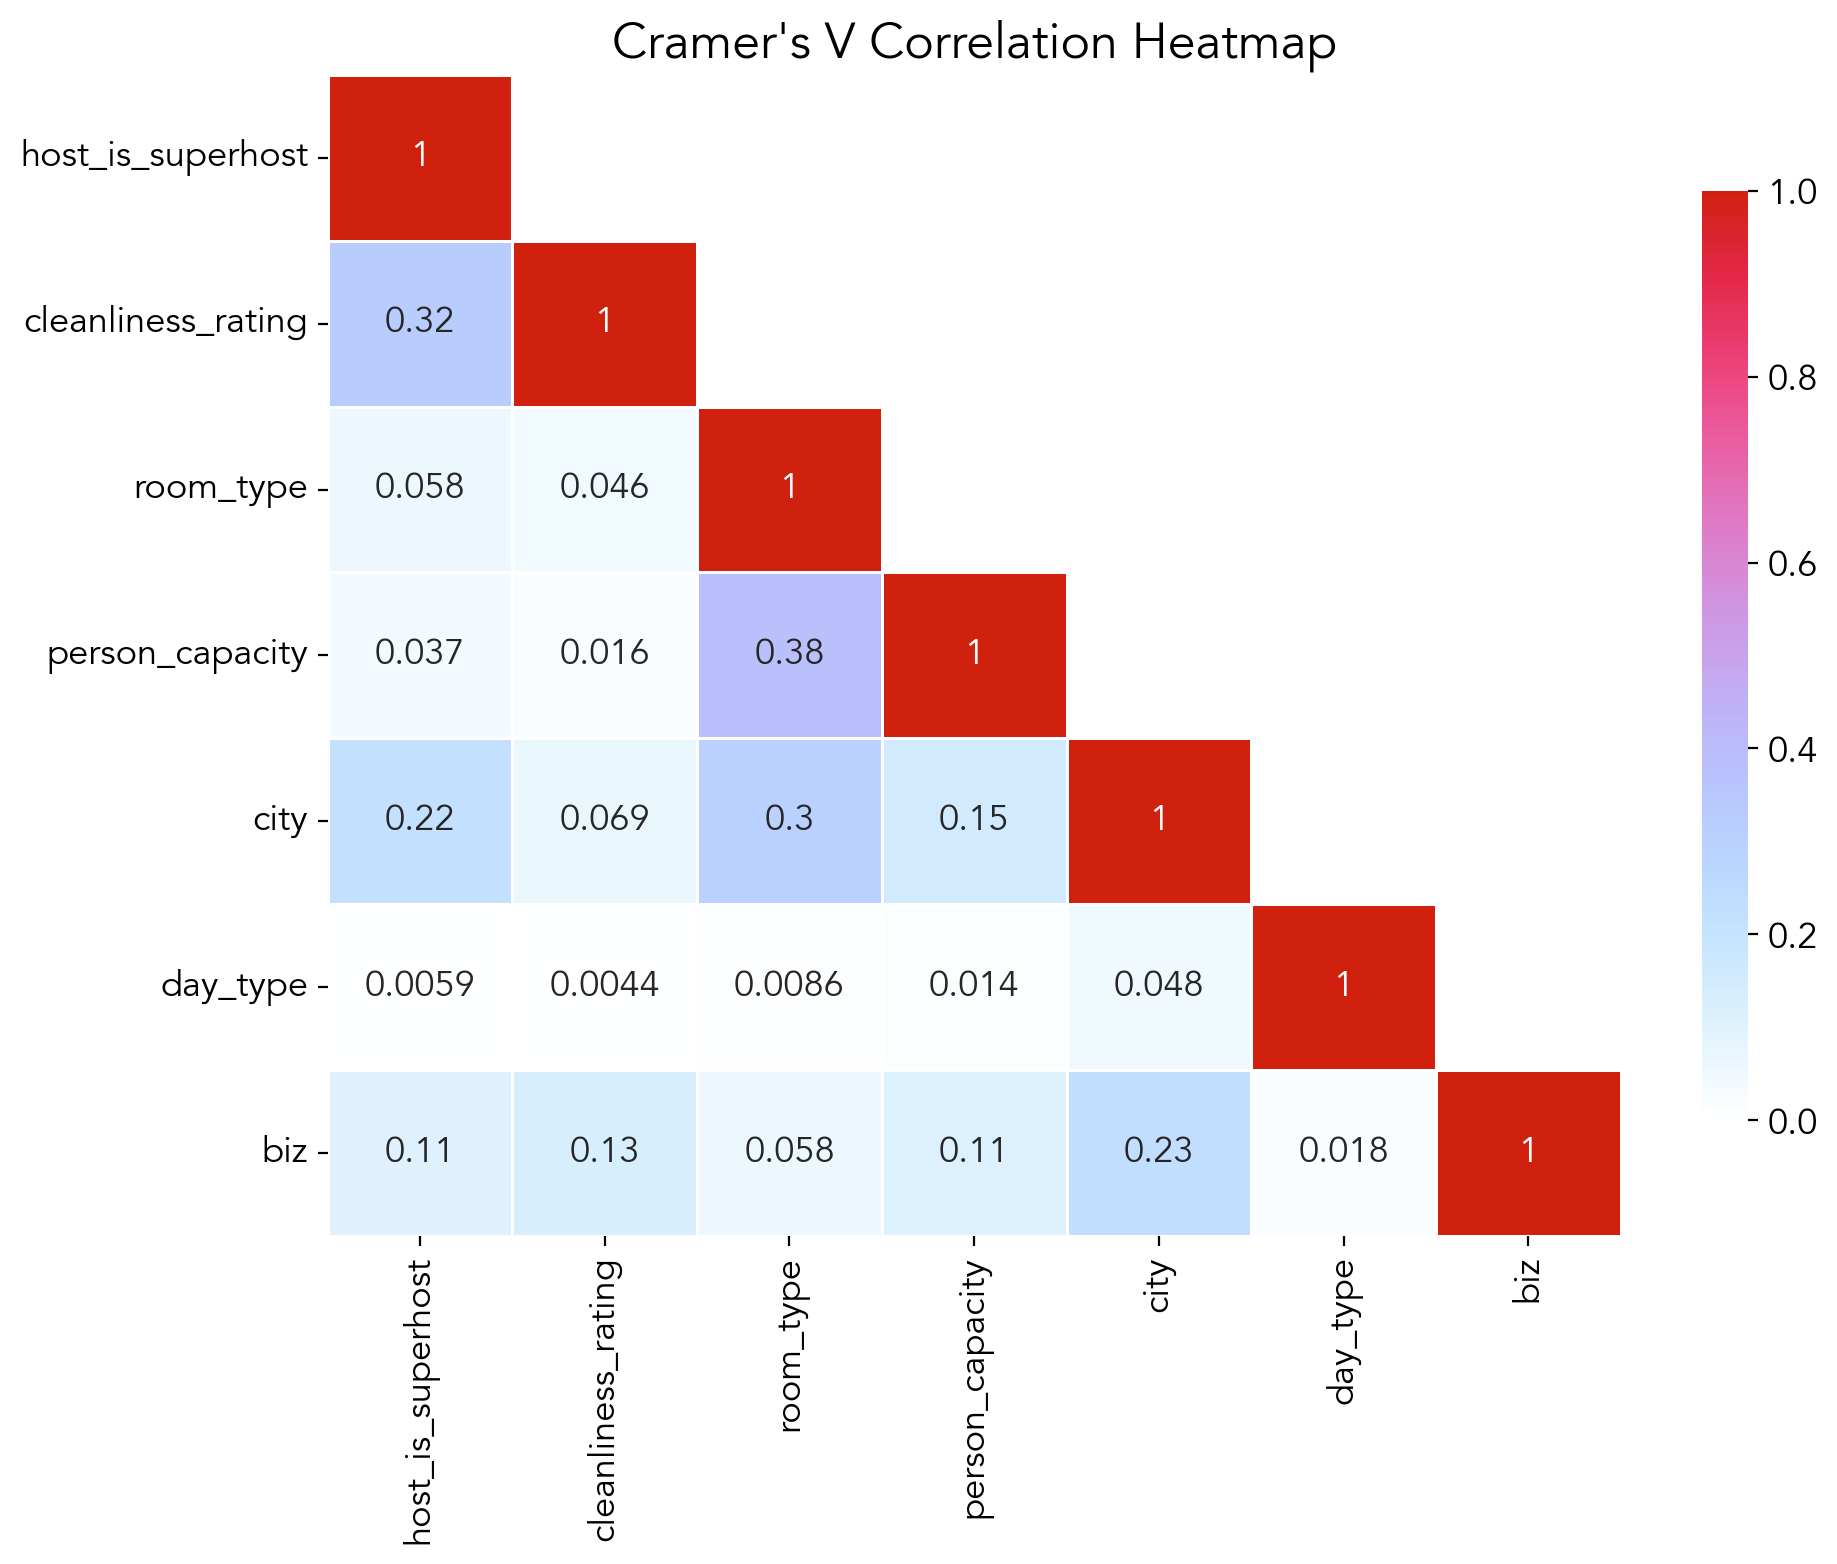

In [7]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cmap import Colormap
from scipy.stats.contingency import association

%config InlineBackend.figure_format = "retina"  # Only for notebooks

# Color maps
cmap1 = "colorcet:cet_l19"
cmap2 = "chrisluts:ygc_3c"
cm1 = Colormap(cmap1).to_mpl()
cm2 = Colormap(cmap2).to_mpl()

# Set font
plt.rcParams["font.family"] = "Avenir"
plt.rcParams["font.size"] = 13

# Define nominal features
nominal_features = [
    "host_is_superhost",
    "cleanliness_rating",
    "room_type",
    "person_capacity",
    "city",
    "day_type",
    "biz",
]

# Copy only nominal columns
df_nominal = df[nominal_features].copy()


def calculate_cramers_v(x, y):
    """Calculate Cramer's V statistic using scipy."""
    confusion_matrix = pd.crosstab(x, y)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        result = association(confusion_matrix, method="cramer")
    return result


def create_cramers_v_matrix(df, features):
    n_features = len(features)
    cramers_matrix = np.zeros((n_features, n_features))
    for i, f1 in enumerate(features):
        for j, f2 in enumerate(features):
            cramers_matrix[i, j] = (
                1.0 if i == j else calculate_cramers_v(df[f1], df[f2])
            )
    return pd.DataFrame(cramers_matrix, index=features, columns=features)


# Compute both matrices
cramers_v_matrix = create_cramers_v_matrix(df_nominal, nominal_features)

# Apply triangle mask
mask = np.triu(np.ones_like(cramers_v_matrix, dtype=bool), k=1)
cramers_v_matrix = cramers_v_matrix.where(~mask)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    cramers_v_matrix,
    ax=ax,
    annot=True,
    cmap=cm1,
    vmin=0,
    vmax=1,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)
ax.set_title("Cramer's V Correlation Heatmap", fontsize=18)
ax.grid(False)

plt.tight_layout()
plt.show()

## Extra plots

/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_67442/3078961222.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_67442/3078961222.py:41: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.violinplot(


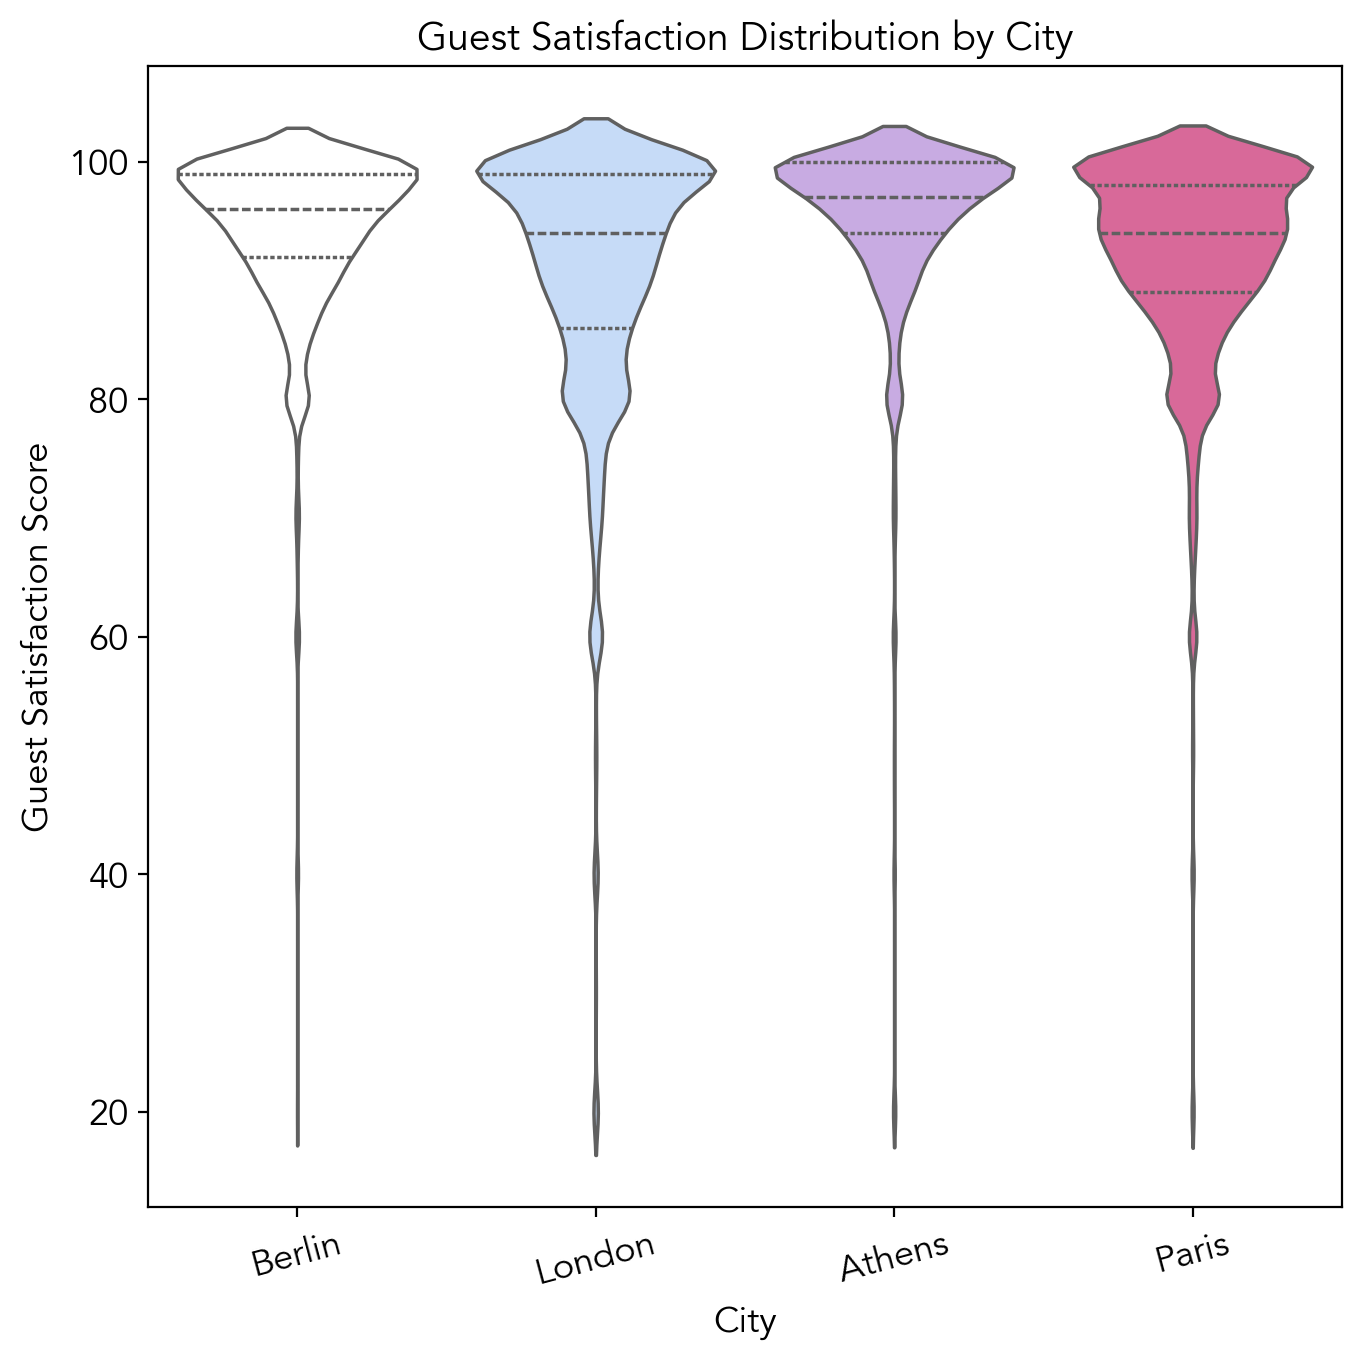

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Create palette function
def create_palette(cmap, n_colors):
    """Create a color palette from a matplotlib colormap."""
    return [cmap(i) for i in np.linspace(0, 1, n_colors)]


# Preprocess
df["city"] = df["city"].str.title()
compare_cities = ["Athens", "Berlin", "Paris", "London", "Madrid"]

df_filtered = df[
    (df["city"].isin(compare_cities))
    & (df["realSum"] < df["realSum"].quantile(0.99))  # remove outliers
    & (df["guest_satisfaction_overall"].notna())
]

# Summary metrics by city
summary = (
    df_filtered.groupby("city")
    .agg(
        avg_price=("realSum", "mean"),
        avg_guest_rating=("guest_satisfaction_overall", "mean"),
        superhost_rate=("host_is_superhost", "mean"),
        avg_cleanliness=("cleanliness_rating", "mean"),
        listing_count=("realSum", "count"),
    )
    .round(2)
    .reset_index()
)


palette = create_palette(cm1, len(compare_cities))
sns.set_palette(palette)

plt.figure(figsize=(7, 7))
sns.violinplot(
    data=df_filtered,
    x="city",
    y="guest_satisfaction_overall",
    inner="quartile",
    palette=palette,
)
plt.title("Guest Satisfaction Distribution by City", fontsize=14)
plt.xlabel("City")
plt.ylabel("Guest Satisfaction Score")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()